# SMAI Assignment - 2

## Question 1: Naive Bayes and Clustering

### Part 1: Naive Bayes

[Files](https://drive.google.com/drive/folders/1OUVrOMp2jSSBDJSqvEyXDFTrhiyZnqit?usp=sharing)

You will be performing Sentiment Analysis on a product review dataset with reviews from customers and star rating belonging to four classes (1,2,4,5). You can use sklearn for this question. Your tasks are as follows:

1.   Clean the text by removing punctations and preprocess them using techniques such as stop word removal, stemming etc. You can explore anything!
1.  Create BoW features using the word counts. You can choose the words that form the features such that the performance is optimised. Use the train-test split provided in `train_test_index.pickle` and report any interesting observations based on metrics such as accurarcy, precision, recall and f1 score (You can use Classification report in sklearn).
1. Repeat Task 2 with TfIdf features.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/SMAI_A2_2024/train_test_index.pickle', 'rb') as handle:
    train_test_index_dict = pickle.load(handle)

In [ ]:
# import pandas as pd
# import pickle

# # Load the train-test indices
# with open('train_test_index.pickle', 'rb') as handle:
#     train_test_index_dict = pickle.load(handle)

# # Load the product reviews data
# data = pd.read_csv('product_reviews.csv')
# data.head()


In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/SMAI_A2_2024/product_reviews.csv')
data.head()

,text,stars,sentiment
0,Total bill for this horrible service? Over $8G...,1.0,0
1,Went in for a lunch. Steak sandwich was delici...,5.0,1
2,This place has gone down hill. Clearly they h...,1.0,0
3,"Walked in around 4 on a Friday afternoon, we s...",1.0,0
4,Michael from Red Carpet VIP is amazing ! I rea...,4.0,1


In [ ]:
import pickle
import pandas as pd
import numpy as np
import string
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/SMAI_A2_2024/product_reviews.csv')

# Load the train-test indices
with open('/content/drive/MyDrive/SMAI_A2_2024/train_test_index.pickle', 'rb') as handle:
    train_test_index_dict = pickle.load(handle)

# Preprocess the text data
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert text to lowercase
    text = text.lower()
    return text

# Apply text preprocessing
data['clean_text'] = data['text'].apply(preprocess_text)

# Define stop words and stemmer
stop_words = ['this', 'is', 'a', 'with', 'and', 'some']
stemmer = PorterStemmer()

# Define function to tokenize and stem text
def tokenize_and_stem(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return stemmed_words

# Create Bag-of-Words features using CountVectorizer
vectorizer = CountVectorizer(analyzer=tokenize_and_stem)
X = vectorizer.fit_transform(data['clean_text'])

# Use the correct column name for the ratings
y = data['stars']

# Split the data into training and testing sets using the provided indices
train_indices = train_test_index_dict['train_index']
test_indices = train_test_index_dict['test_index']
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Train a Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         1.0       0.72      0.76      0.74      1149
         2.0       0.30      0.04      0.08       587
         4.0       0.47      0.53      0.50      1981
         5.0       0.79      0.82      0.81      5082

    accuracy                           0.70      8799
   macro avg       0.57      0.54      0.53      8799
weighted avg       0.68      0.70      0.68      8799



In [ ]:
import pickle
import pandas as pd
import numpy as np
import string
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/SMAI_A2_2024/product_reviews.csv')

# Load the train-test indices
with open('/content/drive/MyDrive/SMAI_A2_2024/train_test_index.pickle', 'rb') as handle:
    train_test_index_dict = pickle.load(handle)

# Preprocess the text data
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert text to lowercase
    text = text.lower()
    return text

# Apply text preprocessing
data['clean_text'] = data['text'].apply(preprocess_text)

# Define stop words and stemmer
stop_words = ['this', 'is', 'a', 'with', 'and', 'some']
stemmer = PorterStemmer()

# Define function to tokenize and stem text
def tokenize_and_stem(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return stemmed_words

# Create TfIdf features using TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer=tokenize_and_stem)
X = vectorizer.fit_transform(data['clean_text'])

# Use the correct column name for the ratings
y = data['stars']

# Split the data into training and testing sets using the provided indices
train_indices = train_test_index_dict['train_index']
test_indices = train_test_index_dict['test_index']
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Train a Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         1.0       0.93      0.02      0.05      1149
         2.0       0.50      0.00      0.00       587
         4.0       0.49      0.01      0.02      1981
         5.0       0.58      1.00      0.73      5082

    accuracy                           0.58      8799
   macro avg       0.62      0.26      0.20      8799
weighted avg       0.60      0.58      0.43      8799



### Part 2: Clustering

You will be performing kmeans clustering on the same product reviews dataset from Part 1. In this question, instead of statistically computing features, you will use the embeddings obtained from a neural sentiment analysis model (huggingface: siebert/sentiment-roberta-large-english).

You can use sklearn for this question. Your tasks are as follows:


1. Perform kmeans clustering using sklearn. Try various values for number of clusters (k) and plot the elbow curve. For each value of k, plot WCSS (Within-Cluster Sum of Square). WCSS is the sum of the squared distance between each point and the centroid in a cluster.
1. Perform task 1 with cluster initialisation methods [k-means++, forgy ("random" in sklearn)].
1. In this case, since the ground truth labels (star rating) are available we can evaluate the clustering using metrics like purity, nmi and rand score. Implement these metrics from scratch and evaluate the clustering. [Reference](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)

In [ ]:
import gzip
import numpy as np

f = gzip.GzipFile('/content/drive/MyDrive/SMAI_A2_2024/roberta_embeds.npy.gz', "r")
embeds = np.load(f)
print(embeds.shape)

(26661, 1024)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

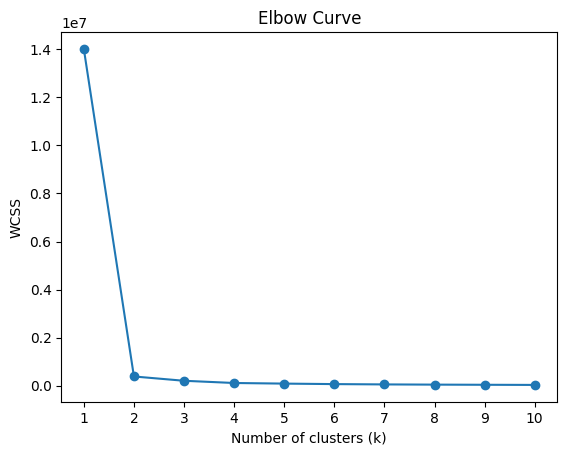

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Task 1: Perform k-means clustering and plot the elbow curve
def plot_elbow_curve(data, max_k=10):
    wcss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.plot(range(1, max_k + 1), wcss, marker='o')
    plt.title('Elbow Curve')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WCSS')
    plt.xticks(range(1, max_k + 1))
    plt.show()

# Plot the elbow curve
plot_elbow_curve(embeds)


In [ ]:
from sklearn.cluster import KMeans

# Define the number of clusters
k = 5

# Initialize KMeans with k-means++
kmeans_pp = KMeans(n_clusters=k, init='k-means++', random_state=0)
kmeans_pp.fit(X_train)

# Initialize KMeans with random initialization
kmeans_random = KMeans(n_clusters=k, init='random', random_state=0)
kmeans_random.fit(X_train)

# Print cluster centers for both initializations
print("Cluster centers for k-means++ initialization:")
print(kmeans_pp.cluster_centers_)

print("\nCluster centers for random initialization:")
print(kmeans_random.cluster_centers_)

Cluster centers for k-means++ initialization:
[[1.06306683e-04 4.72923990e-05 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.33827384e-04 0.00000000e+00 0.00000000e+00 ... 7.86328848e-05
  0.00000000e+00 0.00000000e+00]
 [2.70119599e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.14552465e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.02528096e-04 0.00000000e+00 5.38962674e-05 ... 0.00000000e+00
  8.91205856e-05 8.91205856e-05]]

Cluster centers for random initialization:
[[1.34339479e-04 0.00000000e+00 0.00000000e+00 ... 7.89337759e-05
  0.00000000e+00 0.00000000e+00]
 [6.07326568e-04 0.00000000e+00 5.43254918e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.70689772e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.14325265e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.05408921e-04 4

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Task 2: Perform k-means clustering with different initialization methods
def perform_clustering_with_init_methods(data, k, init_methods=['k-means++', 'random']):
    results = {}
    for init_method in init_methods:
        kmeans = KMeans(n_clusters=k, init=init_method, random_state=42)
        kmeans.fit(data)
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_
        # Calculate the total within-cluster sum of squares (WCSS)
        wcss = sum(np.min(pairwise_distances_argmin_min(data, centroids), axis=1))
        results[init_method] = {'centroids': centroids, 'labels': labels, 'wcss': wcss}
    return results

# Perform clustering with different initialization methods
k = 4  # Number of clusters
results_init_methods = perform_clustering_with_init_methods(embeds, k)

# Print the WCSS for each initialization method
for init_method, result in results_init_methods.items():
    print(f"Initialization Method: {init_method}, WCSS: {result['wcss']}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization Method: k-means++, WCSS: 0.1205825579106051
Initialization Method: random, WCSS: 0.1205825579106051


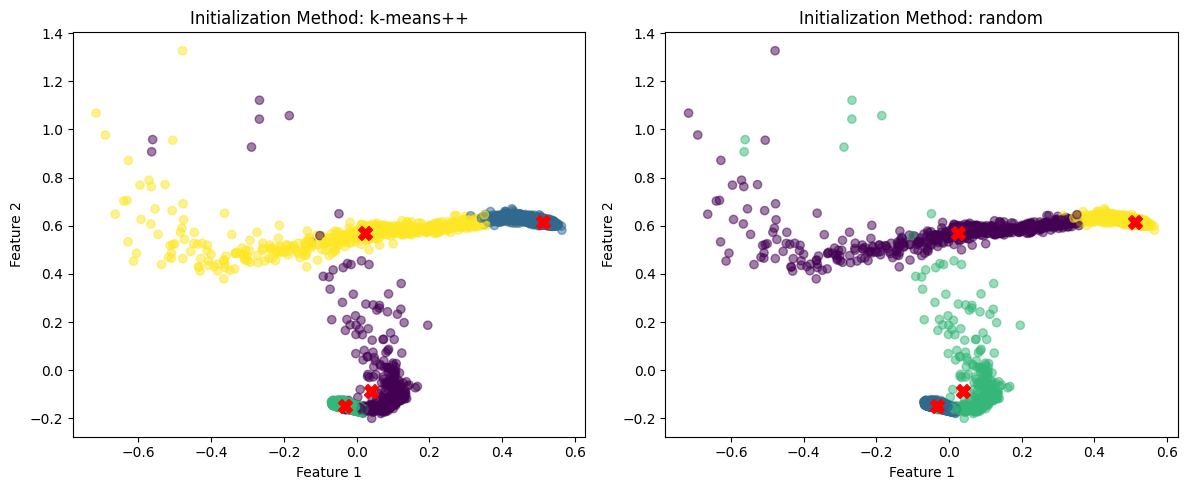

In [ ]:
# Visualize clustering results with centroids for each initialization method
def plot_clustering_results(data, results):
    fig, axs = plt.subplots(1, len(results), figsize=(12, 5))
    for i, (init_method, result) in enumerate(results.items()):
        centroids = result['centroids']
        labels = result['labels']
        axs[i].scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.5)
        axs[i].scatter(centroids[:, 0], centroids[:, 1], marker='X', c='red', s=100)
        axs[i].set_title(f'Initialization Method: {init_method}')
        axs[i].set_xlabel('Feature 1')
        axs[i].set_ylabel('Feature 2')
    plt.tight_layout()
    plt.show()

# Plot clustering results with centroids for each initialization method
plot_clustering_results(embeds, results_init_methods)


In [ ]:
unique_labels_true = np.unique(y_test)
unique_labels_pred = np.unique(labels_pred)

print("Unique true labels:", unique_labels_true)
print("Unique predicted labels:", unique_labels_pred)

Unique true labels: [1. 2. 4. 5.]
Unique predicted labels: [0 1 2 3]


In [ ]:
print(y_test_int.shape)
print(labels_pred.shape)

# Check the maximum value in labels_true and labels_pred
print(np.max(y_test_int))
print(np.max(labels_pred))

(8799,)
(26661,)
4
3


In [ ]:
# Task 3: Evaluate clustering using purity, NMI, and Rand score with custom functions
from scipy.special import comb


def calculate_purity(labels_true, labels_pred):
    # Convert labels_true and labels_pred to integer arrays
    labels_true = np.asarray(labels_true, dtype=int)
    labels_pred = np.asarray(labels_pred, dtype=int)

    # Calculate contingency matrix
    contingency_matrix = np.zeros((len(np.unique(labels_true)), len(np.unique(labels_pred))))
    for i, label_true in enumerate(labels_true):
        contingency_matrix[label_true, labels_pred[i]] += 1

    # Calculate purity
    purity = np.sum(np.max(contingency_matrix, axis=0)) / len(labels_true)
    return purity

def calculate_nmi(labels_true, labels_pred):
    # Convert labels_true and labels_pred to integer arrays
    labels_true = np.asarray(labels_true, dtype=int)
    labels_pred = np.asarray(labels_pred, dtype=int)

    # Calculate contingency matrix
    contingency_matrix = np.zeros((len(np.unique(labels_true)), len(np.unique(labels_pred))))
    for i, label_true in enumerate(labels_true):
        contingency_matrix[label_true, labels_pred[i]] += 1

    # Calculate joint probability
    contingency_matrix = contingency_matrix / len(labels_true)

    # Calculate marginal probabilities
    p_true = np.sum(contingency_matrix, axis=1)
    p_pred = np.sum(contingency_matrix, axis=0)

    # Calculate mutual information
    mi = 0
    for i in range(len(np.unique(labels_true))):
        for j in range(len(np.unique(labels_pred))):
            if contingency_matrix[i, j] > 0:
                mi += contingency_matrix[i, j] * np.log((contingency_matrix[i, j] / (p_true[i] * p_pred[j])))

    # Calculate normalized mutual information
    h_true = -np.sum(p_true * np.log(p_true))
    h_pred = -np.sum(p_pred * np.log(p_pred))
    nmi = mi / np.sqrt(h_true * h_pred)
    return nmi

def calculate_rand_score(labels_true, labels_pred):
    # Convert labels_true and labels_pred to integer arrays
    labels_true = np.asarray(labels_true, dtype=int)
    labels_pred = np.asarray(labels_pred, dtype=int)

    # Calculate contingency matrix
    contingency_matrix = np.zeros((len(np.unique(labels_true)), len(np.unique(labels_pred))))
    for i, label_true in enumerate(labels_true):
        contingency_matrix[label_true, labels_pred[i]] += 1

    # Calculate Rand index
    a = 0
    b = 0
    n_samples = len(labels_true)
    for i in range(len(np.unique(labels_true))):
        for j in range(i + 1, len(np.unique(labels_true))):
            a += comb(contingency_matrix[i, j] + contingency_matrix[j, i], 2)
    for i in range(len(np.unique(labels_pred))):
        for j in range(i + 1, len(np.unique(labels_pred))):
            b += comb(contingency_matrix[i, j] + contingency_matrix[j, i], 2)

    rand_index = (2 * (a + b)) / (n_samples * (n_samples - 1))
    return rand_index

# Evaluate clustering performance
init_methods = list(results_init_methods.keys())
purity_scores = []
nmi_scores = []
rand_scores = []

# Convert true labels to integer values starting from 0
y_test_int = y_test.astype(int) - 1

for init_method, result in results_init_methods.items():
    labels_pred = result['labels']
    purity = calculate_purity(y_test_int, labels_pred)
    nmi = calculate_nmi(y_test_int, labels_pred)
    rand_score = calculate_rand_score(y_test_int, labels_pred)
    purity_scores.append(purity)
    nmi_scores.append(nmi)
    rand_scores.append(rand_score)

# Plot bar plots for each metric
x = np.arange(len(init_methods))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

purity_bars = ax.bar(x - width, purity_scores, width, label='Purity')
nmi_bars = ax.bar(x, nmi_scores, width, label='NMI')
rand_bars = ax.bar(x + width, rand_scores, width, label='Rand Score')

ax.set_xlabel('Initialization Method')
ax.set_ylabel('Score')
ax.set_title('Clustering Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(init_methods)
ax.legend()

plt.show()


IndexError: index 4 is out of bounds for axis 0 with size 4